In [1]:
using Polyhedra
using MeshCat
using Distributions, Random
using Plots
using LinearAlgebra
using GeometryBasics

## Maximum Likelihood Estimation for MNL Model
### Problem Formulation

First we specify the type of data that we can collect. The data contains a total of $N$ choice observations from the same group of consumers. Let $\mathbf{T}^{(N)}:=(T_i)_{i=1}^N$ be the sequence of the choice set (repetition is allowed). Let $\mathbf{s}^{(N)}:(s_i)_{i=1}^N,\ s_i\in T_i$ be the sequence of observed chosen option for each choice set $T_i$. The data can then be formally represented as $\mathbf{x}^{(N)}:=(\mathbf{s}^{(N)},\mathbf{T}^{(N)})$. We formulate the estimation of choice model as a maximum likelihood estimation. The likelihood function can be represented as the following:

$$
\mathcal{L}(\mathbf{x}^{(N)}):= \sum_{n\in[N]} \log\ p(s_n,T_n \mid \mathbf{Q}),
$$

where $\mathbf{Q}$ are the estimated parameters and $p(s,T|\mathbf{Q})$ is the choice function for the estimated choice model. Our main goal is to find the optimal solution $\mathbf{Q^*}$ to maximize the likelihood function.

For Luce model, 

$$
\mathbf{Q} = \{u(s)\in\mathbb{R^+},\ s\in S\},
$$

$$
p(s_n,T_n|\mathbf{Q}) = \frac{u(s_n)}{\sum_{t\in T_n}u(t)}.
$$

Therefore, the estimation problem can be formulated as the following:

$$
\max_{\boldsymbol{\pi}} \; \sum_{n \in [N]}
\Big( \log(u(s_n)) - \log\!\Big(\sum_{t\in T_n}u(t)\Big) \Big).
$$

Re-parameterizing $u(t) = e^{v(t)}$, we can easily check that the log likelihood function of $v(t)$ is concave. Problem can be reformulated as:

$$
\max_{\boldsymbol{\pi}} \; \sum_{n \in [N]} v(s_n)
- \sum_{n\in[N]} \log\!\Big(\sum_{t\in T_n}e^{v(t)}\Big).
$$

The first term is linear, and the second term is concave (we can check this by calculating the Hessian matrix). Therefore, the problem becomes maximizing a concave function over a convex feasible set. This problem is well studied in optimization literature. 

The mostly related paper is **On Sinkhorn’s Algorithm and Choice Modeling, 2025**. They discuss the following results:

1. The uniqueness of the maximizer exists if and only if the following condition holds:
    * **(Connectivity)** In any partition of $S$ into $T$ and $S-T$, some option $j\in T$ and some option $k\in S-T$ appear in the same observed choice set $T_n$
2. The optimality condition for Luce-MLE:
    * For each option $j\in S$, by first order condition $u(j)$ must satisfies the following equation:
    $$\delta_{u(j)} \mathcal{L} = \sum_{n\in[N]: s_n = j}\frac{1}{u(j)}-\sum_{n\in[N]:j\in T_n}\frac{1}{\sum_{t\in T_n}u(t)} =0.$$
3. The equation system defined by optimality condition can be formulated as a matrix balancing problem and solved by Sinkhorn’s algorithm.




## MNL parameters and $log(\mathcal{L})$ polytope

In [2]:
Random.seed!(42)
d = Dirichlet(fill(1.0,3))    
X = rand(d, 3000) 
X₀ = X';

Assume our observation data is 

|   | s (choice) | T (choice set) |
|---|---|-----|
| 1 | a | ab |

Thus, the likelyhood function is the following
$$\mathcal{L} = \frac{u(a)}{u(a)+u(b)},$$

$$\Rightarrow log(\mathcal{L}) = log(u(a))-log(u(a)+u(b)).$$


In [3]:
function add_row(X::AbstractMatrix, f::Function)
    extra = [f(row) for row in eachrow(X)]   
    return hcat(X, extra)
end

# Likelihood function for our observations under Multimomial Logit Model
# We can play around with this function. Under some certain observations, this function is concave.
# For example, we observe a being picked from abc. Then the p = u(a), as u(a)+u(b)+u(c) = 1
MNL_pfunction(v)=v[1]/(v[1]+v[2])
#loglikelihood funtion
logpfunction(v) = log(v[4])

X₁ = add_row(X₀,MNL_pfunction)

#5-dimensional vector of (parameters (3 dimensions), likelihood funtion, log likelihood)
X₂ = add_row(X₁,logpfunction)
vecs = [collect(row) for row in eachrow(X₂)];

#generate the (u1,u2,u3,p,logp) polytope
MNL_vrep = vrep(vecs)
MNL_poly = polyhedron(MNL_vrep)

u_logp_proj = project(MNL_poly,[1,2,5]);

In [4]:
m = Polyhedra.Mesh(u_logp_proj)
material_m = MeshPhongMaterial(color=RGBA(1.0, 0.0, 0.0, 0.5), 
                             )
points = [Point3f(p[1], p[2], p[5]) for p in vecs]
colors = [RGB(0.0,1.0,0.0) for p in points]
pc = PointCloud(points, colors)

vis = Visualizer()
# setobject!(vis["conv"], m, material_m)
setobject!(vis["points"], pc)
IJuliaCell(vis)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("points" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x69, 0x6e, 0x74, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000025d0) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable, started) @0x000001a64a9eee90, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 141733920768))), MeshCat.AnimationContext[]))

## Choice Domain of RUM and MNL

In this section, I will visualize the choice domain $p$ of Random Utility model and MNL model. Here I take a special case where there is 3 products in the choice set. We can easily check that $p\in\mathbb{R}^5$.

In [5]:
using LinearAlgebra

In [29]:
# MNL model
MNL_P₁₂(v) = v[1]/(v[1]+v[2])
MNL_P₁₃(v) = v[1]/(v[1]+v[3])
MNL_P₂₃(v) = v[2]/(v[2]+v[3])
MNL_P₁(v) = v[1]/(v[1]+v[2]+v[3])
MNL_P₂(v) = v[2]/(v[1]+v[2]+v[3])

Random.seed!(42)

d = Dirichlet(fill(1.0,3))
U = rand(d, 20000)' 


MNL_P = [[MNL_P₁₂(v), MNL_P₁₃(v), MNL_P₂₃(v), MNL_P₁(v), MNL_P₂(v)] for v in eachrow(U)]

#convex hull of MNL model
MNL_Pvrep = vrep(MNL_P)
MNL_Ppoly = polyhedron(MNL_Pvrep);

In [30]:
#RUM model
RUMP1(v) = v[1]+v[2]+v[5]
RUMP2(v) = v[1]+v[2]+v[3]
RUMP3(v) = v[1]+v[3]+v[4]
RUMP4(v) = v[1]+v[2]
RUMP5(v) = v[3]+v[4]

#6 types
X = Matrix(I,6,6)

RUM_P = [[RUMP1(v), RUMP2(v), RUMP3(v), RUMP4(v), RUMP5(v)] for v in eachrow(X)]
RUM_Pvrep = vrep(RUM_P)
RUM_Ppoly = polyhedron(RUM_Pvrep);

In [31]:
# As we cannot visualize a 5 dimension object, we now project these 2 polytope down to 2 dimension and 3 dimension
MNL = project(MNL_Ppoly, [4,5]);
RUM = project(RUM_Ppoly, [4,5]);

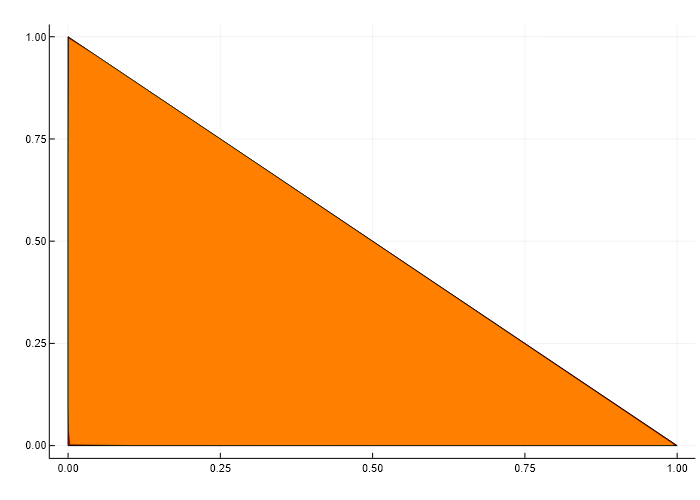

In [32]:
plotlyjs()
plot(RUM, alpha = 1, color = "red")
plot!(MNL, alpha = 0.5, color = "yellow")

In [33]:
MNL_3D = project(MNL_Ppoly, [1,2,3]);
RUM_3D = project(RUM_Ppoly, [1,2,3]);

In [34]:
m = Polyhedra.Mesh(RUM_3D)
n = Polyhedra.Mesh(MNL_3D)
vis = Visualizer()
material_m = MeshPhongMaterial(color=RGBA(1.0, 0.0, 0.0, 0.5), 
                             )
material_n = MeshPhongMaterial(color=RGBA(0.0, 1.0, 0.0, 1.0), 
                             )

setobject!(vis["poly_m"], m, material_m)
setobject!(vis["poly_n"], n, material_n)
IJuliaCell(vis)

[ Info: Listening on: 127.0.0.1:8708, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8708


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("poly_n" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x79, 0x5f, 0x6e], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "poly_m" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x79, 0x5f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8708, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8708), "127.0.0.1", "8708", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001c3c) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable, started) @0x000001a655f11750, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (-4618947739541145056, -4622692889133221553, 4587220520229431785))), MeshCat.AnimationContext[]))

The preceding 2D and 3D graph show that the convex hull of MNL is RUM. 

In [35]:
RUM_Phrep = doubledescription(RUM_Pvrep)

for i in 1:length(MNL_P)
    if in(MNL_P[1], RUM_Phrep) != true
        return false
    end
    return true
end

true

The preceding result shows that MNL is nested in RUM

In [36]:
using GeometryBasics

In [37]:
# Here we preserve the original sample points of MNL without any convexification and see the relationship between RUM and MNL
points = [Point3f(p[1], p[2], p[3]) for p in MNL_P]
colors = [RGB(0.0,0.0,1.0) for p in points]
pc = PointCloud(points, colors)

vis = Visualizer()
setobject!(vis["poly_m"], m, material_m)
setobject!(vis["point"], pc)

IJuliaCell(vis)

[ Info: Listening on: 127.0.0.1:8709, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8709


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "poly_m" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x79, 0x5f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8709, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8709), "127.0.0.1", "8709", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000023a4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable, started) @0x000001a65f7362f0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4598184922075138761, 4592529815466129484, 4596552470445509241))), MeshCat.AnimationContext[]))

P is projected down to the first 3 dimensions. Red zone is RUM, while blue dots are MNL.

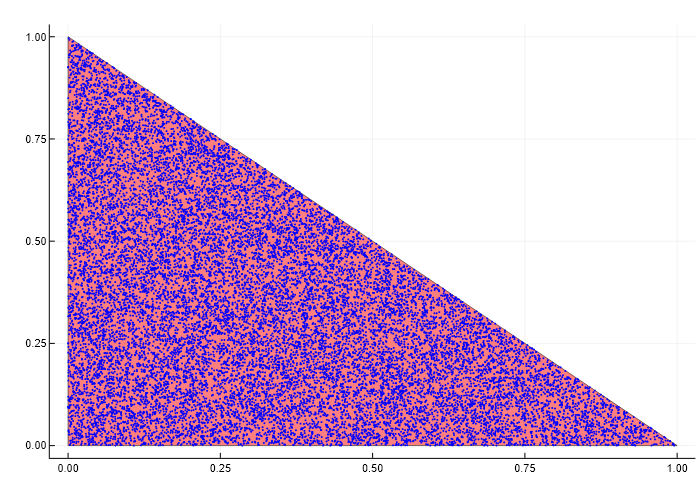

In [15]:
x = [p[4] for p in MNL_P]
y = [p[5] for p in MNL_P]

plot(RUM, alpha = 0.5, color = "red")
scatter!(x, y, alpha = 1, color = "blue", markersize=1, markerstrokewidth=0)

P is projected down to the last 2 dimensions. Red zone is RUM, while blue dots are MNL.

##  2-type Mixture Model

Next we want to develop the characterization theorem for k-mixed MNL model. We know that the convex hull of Luce choice domain is the RUM choice domain. But here we only allow for the convex combination of $k$ vectors in Luce choice domain.

$$
\text{conv}(\mathcal{Luce}) =
\left\{\sum_{i=1}^m \lambda_i \mathbf{p}_i : \mathbf{p}_i \in \mathcal{Luce},\ 
\sum_{i=1}^m \lambda_i = 1,\ m \in \mathbb{N}^+\right\}
= \mathcal{RUM},
$$

$$
\mathcal{k\text{-}mixed\ Luce} =
\left\{\sum_{i=1}^k \lambda_i \mathbf{p}_i : \mathbf{p}_i \in \mathcal{Luce},\ 
\sum_{i=1}^k \lambda_i = 1\right\},
$$

where $\mathcal{Luce}\subseteq \mathbb{R}^{|S|\times 2^{|S|}}$ represents the choice domain of Luce model, and $\mathcal{RUM}\subseteq \mathbb{R}^{|S|\times 2^{|S|}}$ represents the choice domain of RUM.

In combinatorics literature, there is a famous Carathéodory's theorem, which is similar to our goal.

**Theorem (Carathéodory).**  
If $x\in \text{conv}(S)\subset \mathbb{R}^d$, then $x$ is the convex sum of at most $d+1$ points of $S$.

Carathéodory's theorem tells us that if $k \geq |S|$ (since the Luce model only has $|S|-1$ degrees of freedom), then

$$
\mathcal{k\text{-}mixed\ Luce} = \text{conv}(\mathcal{Luce}) = \mathcal{RUM}.
$$

It remains to discuss the circumstances where $k < |S|$. From the graph demonstration, my conjecture is that

$$
\mathcal{k\text{-}mixed\ Luce}\ ?= \text{conv}(\mathcal{Luce}) = \mathcal{RUM},\quad \forall k \geq 2.
$$


In [16]:
Random.seed!(30)

d = Dirichlet(fill(1.0,3))
U = rand(d, 500)' 
MNL_P = [[MNL_P₁₂(v), MNL_P₁₃(v), MNL_P₂₃(v), MNL_P₁(v), MNL_P₂(v)] for v in eachrow(U)]

λset = [0.2, 0.4, 0.6, 0.8]
twoMNL_P = []

for i in 1:length(MNL_P)
    for j in i+1:length(MNL_P)
        v1 = MNL_P[i]
        v2 = MNL_P[j]
        for λ in λset
            point = λ*v1 + (1-λ)*v2
            push!(twoMNL_P, point)
        end
    end
end     

In [17]:
points = [Point3f(p[1], p[2], p[3]) for p in twoMNL_P]
colors = [RGB(0.0,0.0,1.0) for p in points]
pc = PointCloud(points, colors)

vis = Visualizer()
setobject!(vis["poly_m"], m, material_m)
setobject!(vis["point"], pc)

IJuliaCell(vis)

[ Info: Listening on: 127.0.0.1:8703, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8703


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "poly_m" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x79, 0x5f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8703, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8703), "127.0.0.1", "8703", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000000dc4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable, started) @0x000001a654aa5b30, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4603895539022084184, 4603313401573365324, 4595733436907593557))), MeshCat.AnimationContext[]))